# 40 kHz Scans

40 kHz sound signal from piezo was recorded using microphone and Sagnac. This data allows us to see 

In [2]:
from analysis import System

sagnac_40kHz = System("sagnac", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)], SNR_freq_cut = 1e6)
mic_40kHz = System("mic", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)], SNR_freq_cut = 2e5)

In [172]:
import matplotlib.pyplot as plt

sag_dat, mic_dat = sagnac_40kHz.get_data()[1], mic_40kHz.get_data()[1]
fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0.00005, 0.00008])
ax[1].set_xlim([0.00005, 0.00008])
fig.suptitle("Sagnac vs. Mic 40kHz Scans")
for sag_shot, mic_shot in zip(sag_dat.collection, mic_dat.collection):
    ax[0].plot(sag_shot.t, sag_shot.x)
    ax[1].plot(mic_shot.t, mic_shot.x)
        

NameError: name 'sagnac_40kHz' is not defined

# Ablation Energy Scans (20 shots)
### Starting energy = 11J
### Ending energy = 13J
##### Phi = 19

Data loaded into System class:

In [4]:
from analysis import System

sagnac_ene_scan = System("sagnac", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 1e6)
mic_ene_scan = System("mic", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 2e5)

Here I take the Daici correction function and apply it to the Sagnac data using apply("correct"). I have some issues with this strategy. Firstly, I'm unsure of the transfer function, so I'll be checking it against the impulse response later in the data analysis. I also have disabled the mic_correct on the microphone channel. This correction has been found to be inaccurate, and it adds a "ghosting" or pre-ringing/pre-echo to the mic signal. This is unacceptable. I'll be investigating how to correct this.

In [1]:
import matplotlib.pyplot as plt

def Daici(freq, dist = 0.033, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

for i, (s_dat, m_dat) in enumerate(zip(sagnac_ene_scan.get_data(), mic_ene_scan.get_data())):
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]
    
    s_dat.apply("correct", tmin = 0.00022, tmax = 0.00027, response = Daici, recollect = True)
    s_dat.apply("detrend", mode = "constant", inplace = True)

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    ax[0].set_title("Sagnac")
    ax[0].set_xlim([0.00023, 0.00026])
    ax[1].set_title("Mic")
    ax[1].set_xlim([0.00023, 0.00026])
    fig.suptitle("Sagnac vs Mic, Ablation Energy = " + str(s_dat.ene))
    for s_shot, m_shot in zip(s_dat.collection[2:], m_dat.collection[2:]):
        s_dat.aggrigate(collection_slice = slice(2, len(s_dat.collection), 1))
        ax[0].plot(s_shot.t, s_shot.x)
        s_dat.agg.plot(ax = ax[0], c = "k")
        m_dat.aggrigate(collection_slice = slice(2, len(m_dat.collection), 1))
        ax[1].plot(m_shot.t, m_shot.x)
        m_dat.agg.plot(ax = ax[1], c = "k")
    
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]

NameError: name 'sagnac_ene_scan' is not defined

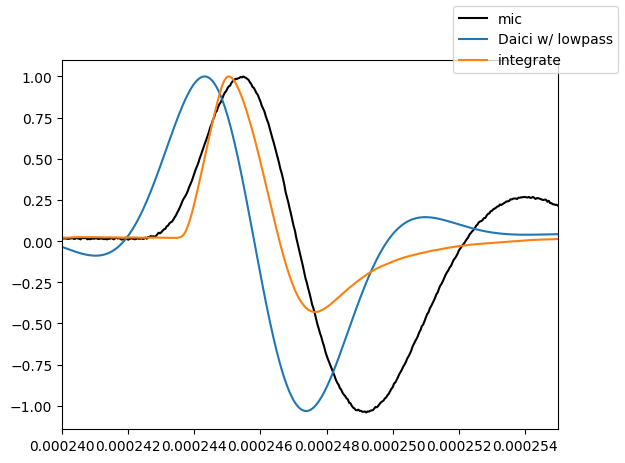

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlim([0.00024, 0.000255])

m_dat.apply("calibrate", cal = 1 / max(m_dat.collection[8].x), inplace = True)
t, x = m_dat.collection[8].t, m_dat.collection[8].x

ax.plot(t, x, label = "mic", c = "k")

sagnac_ene_scan.set_data(ind = 19)
s_dat = sagnac_ene_scan.get_data()[19]
mic_ene_scan.set_data(ind = 19, mic_correct = False)
m_dat = mic_ene_scan.get_data()[19]

# s_dat.apply("detrend", mode = "constant", inplace = True)
# s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
# t, x = s_dat.collection[8].t, s_dat.collection[8].x
# ax.plot(t, x, label = "raw")
# sagnac_ene_scan.set_data(ind = 19)
# s_dat = sagnac_ene_scan.get_data()[19]


s_dat.apply("detrend", mode = "constant", inplace = True)
s_dat.apply("correct", tmin = 0.00022, tmax = 0.00027, response = Daici, recollect = True)
# s_dat.apply("lowpass", cutoff = 2e5, inplace = True)
s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
t, x = s_dat.collection[8].t, s_dat.collection[8].x
ax.plot(t, x, label = "Daici w/ lowpass")
sagnac_ene_scan.set_data(ind = 19)
s_dat = sagnac_ene_scan.get_data()[19]

# s_dat.apply("detrend", mode = "constant", inplace = True)
# s_dat.apply("correct", response = integrate, recollect = True)
# s_dat.apply("calibrate", cal = -1, inplace = True)
# s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
# t, x = s_dat.collection[8].t, s_dat.collection[8].x
# ax.plot(t, x, label = "integrate")
# sagnac_ene_scan.set_data(ind = 19)
# s_dat = sagnac_ene_scan.get_data()[19]

sagnac_ene_scan.set_data(ind = 19)
s_dat = sagnac_ene_scan.get_data()[19]
mic_ene_scan.set_data(ind = 19, mic_correct = False)
m_dat = mic_ene_scan.get_data()[19]
fig.legend()

In [1]:
from analysis import System

sagnac_ene_scan = System("sagnac", ["../data/20240105/ablation-ene-scan-11-12-20_phi-154_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR = False)
mic_ene_scan = System("mic", ["../data/20240105/ablation-ene-scan-11-12-20_phi-154_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR = False)

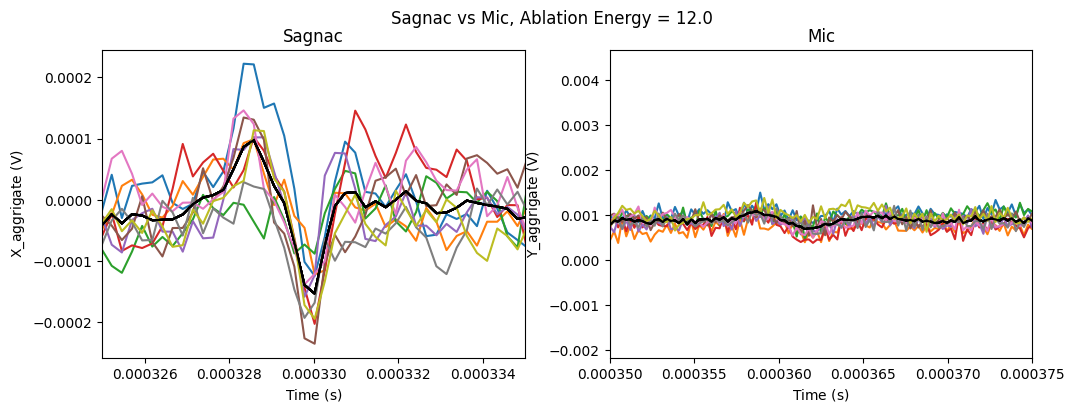

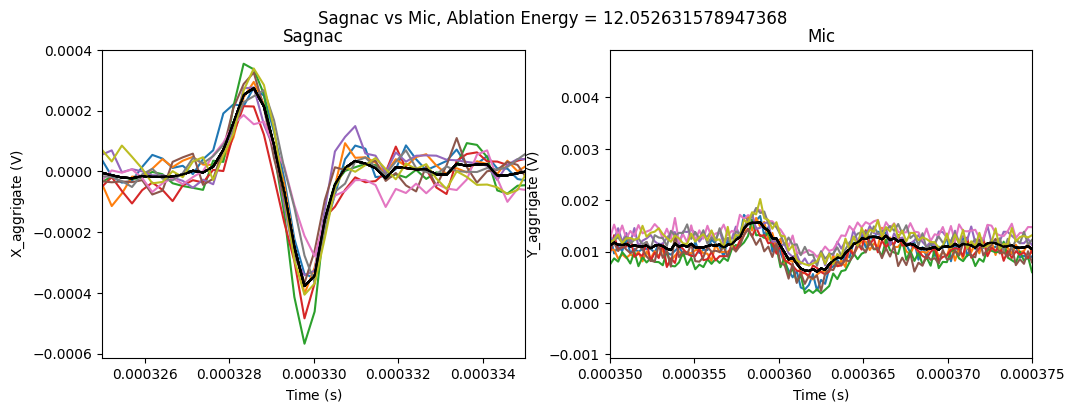

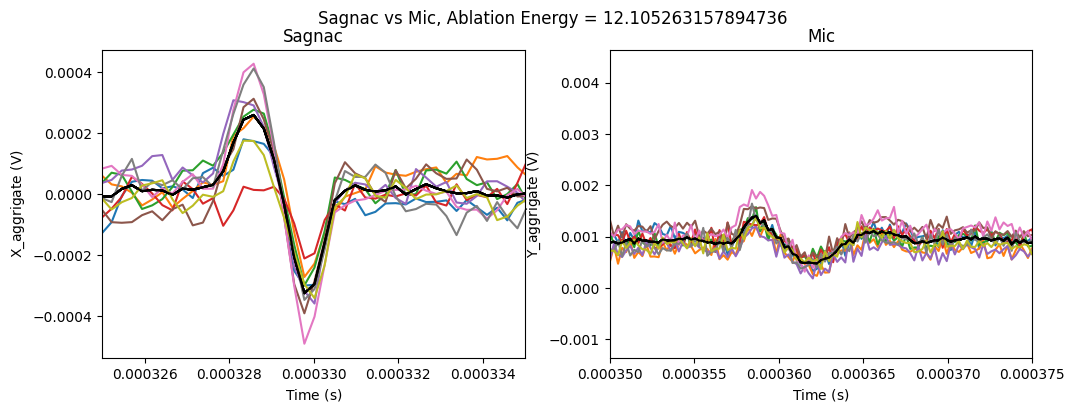

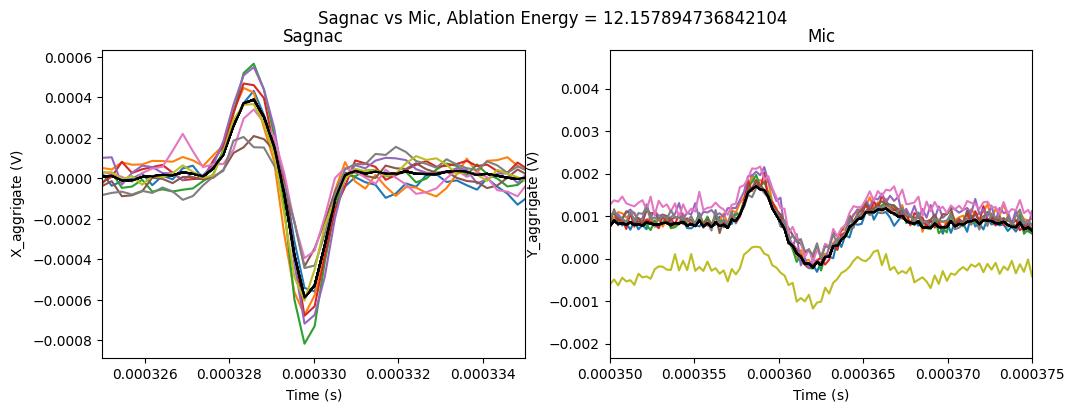

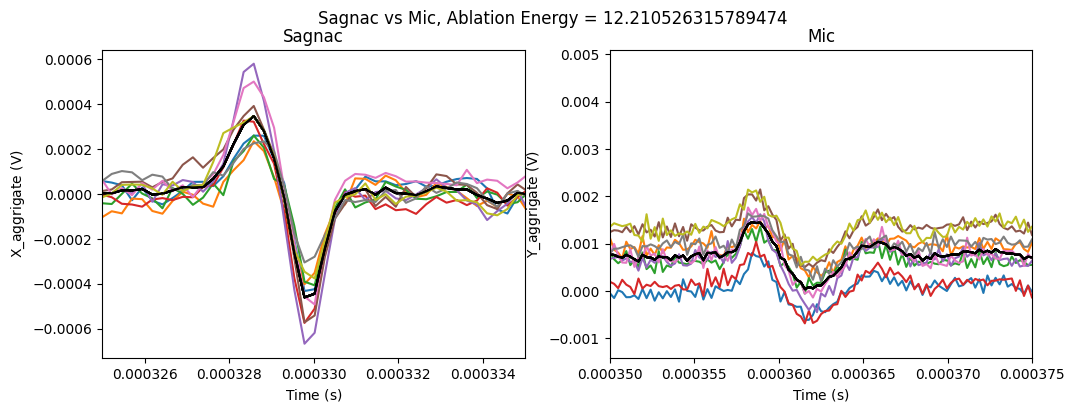

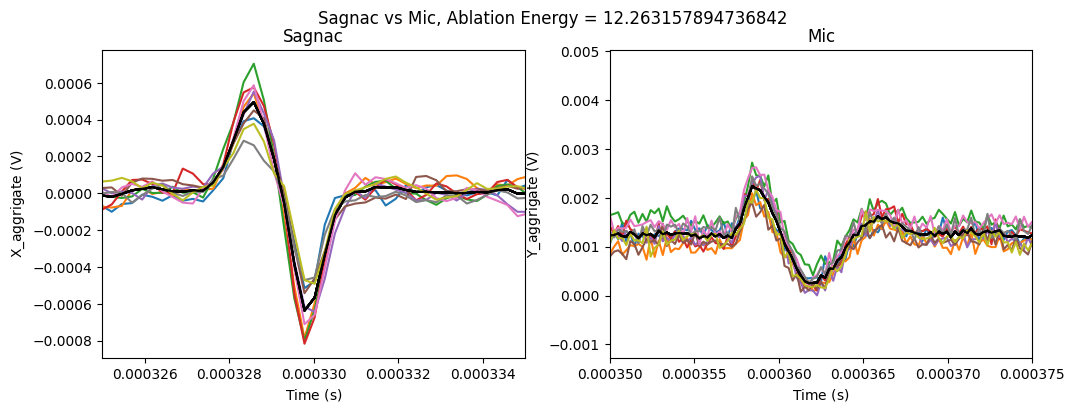

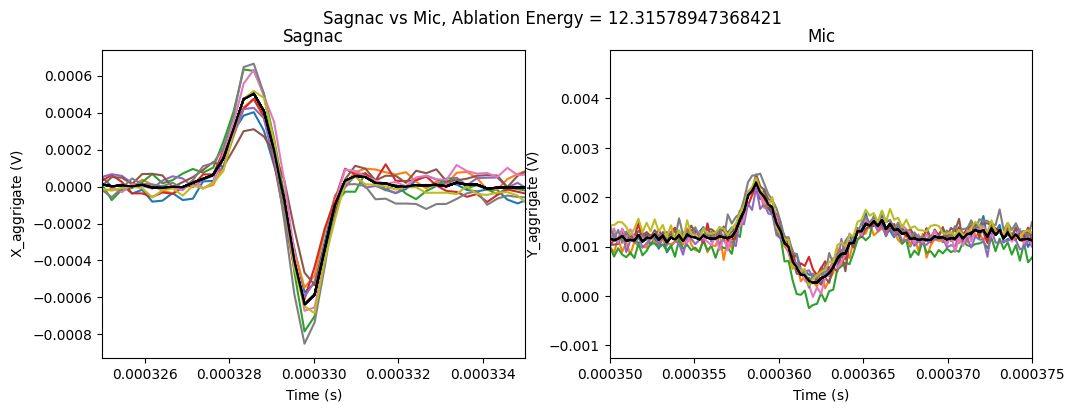

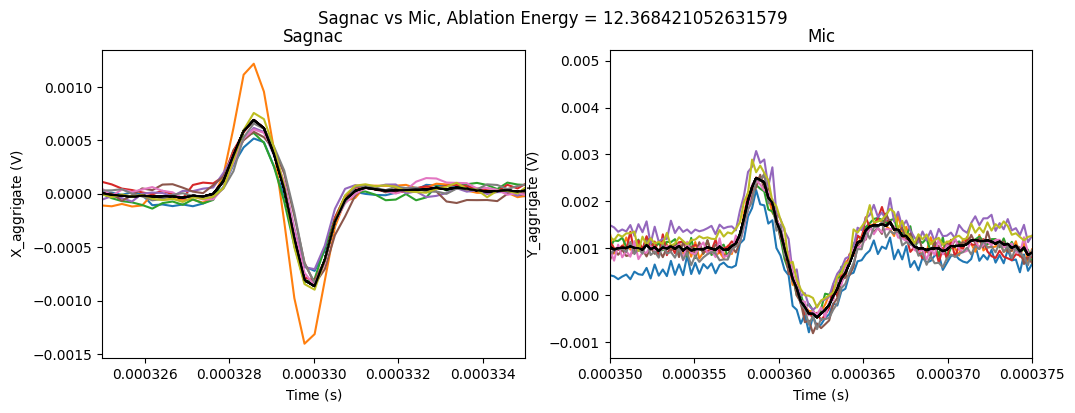

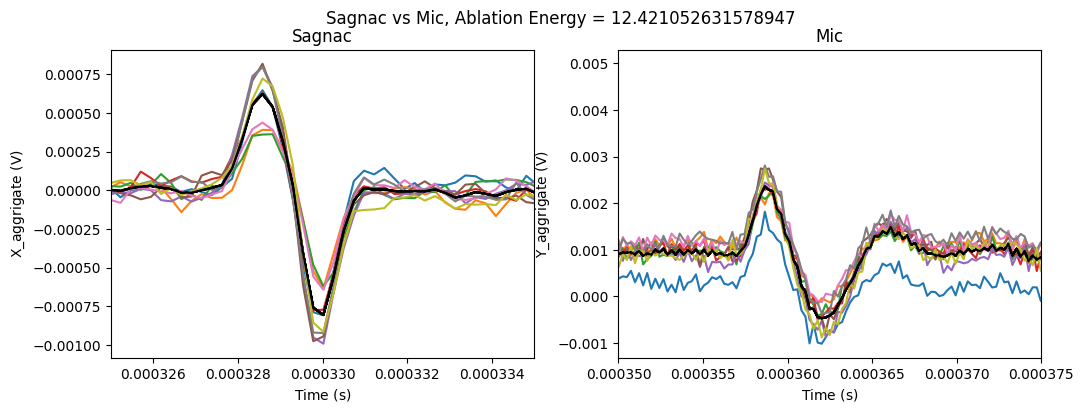

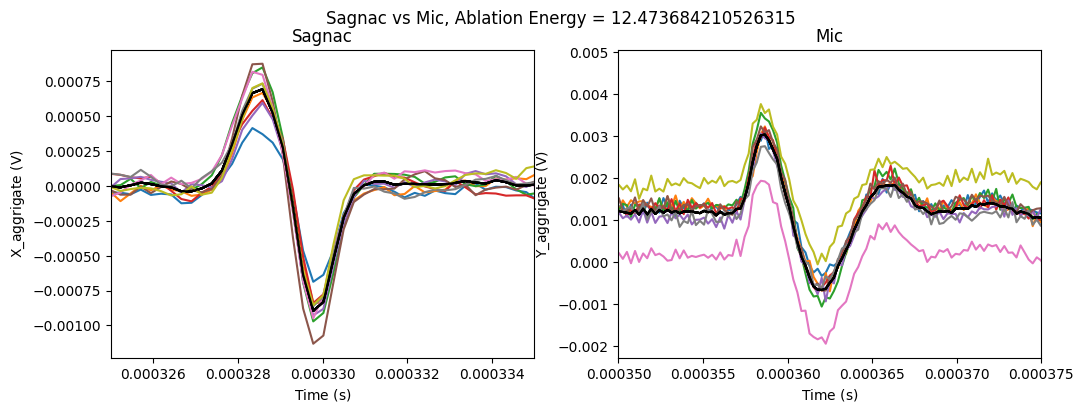

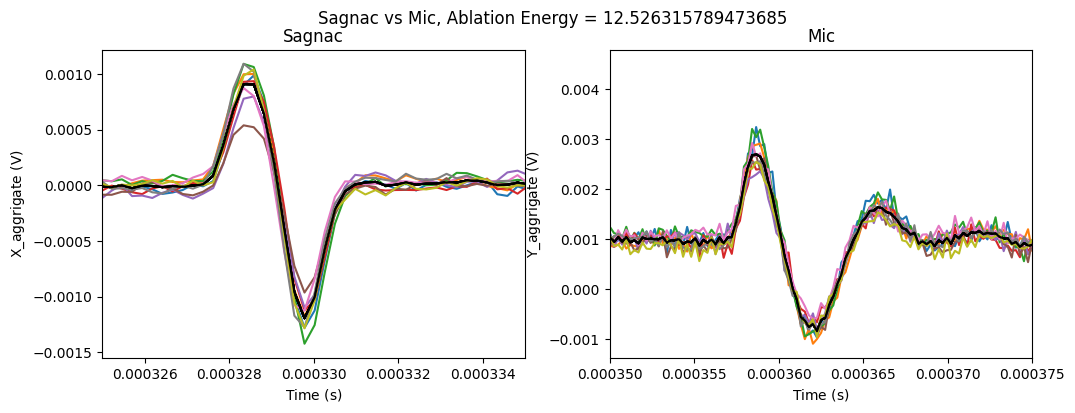

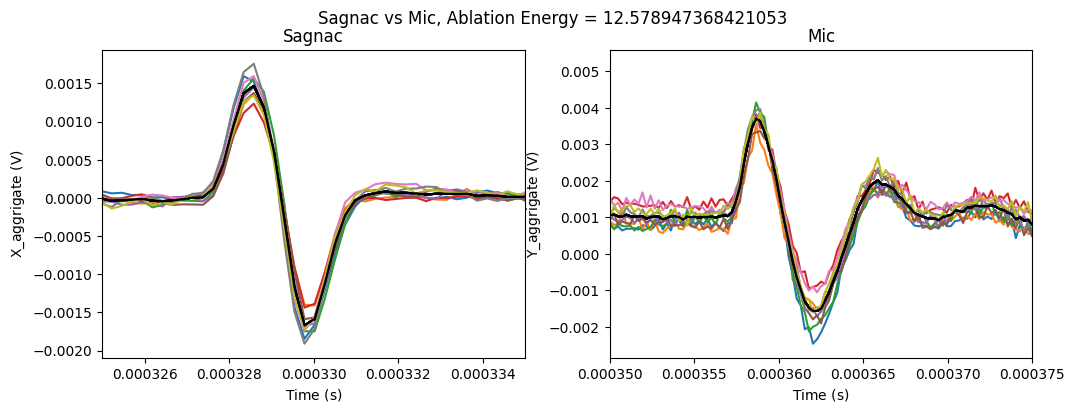

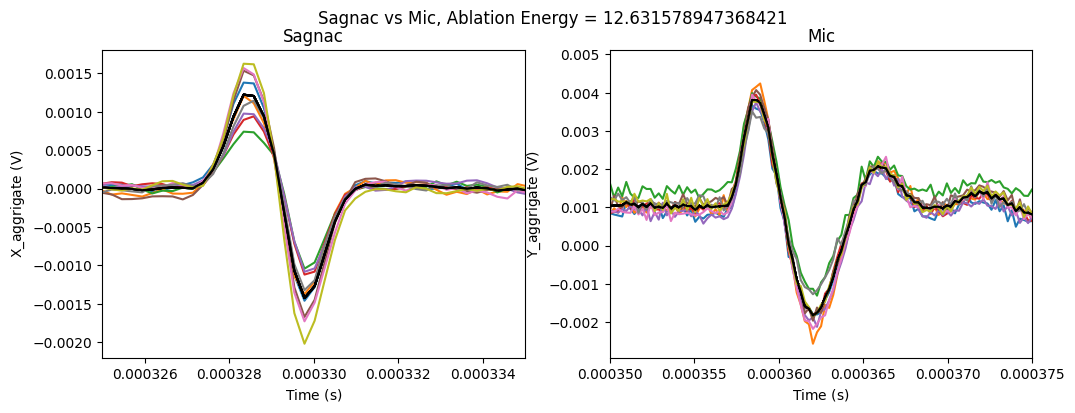

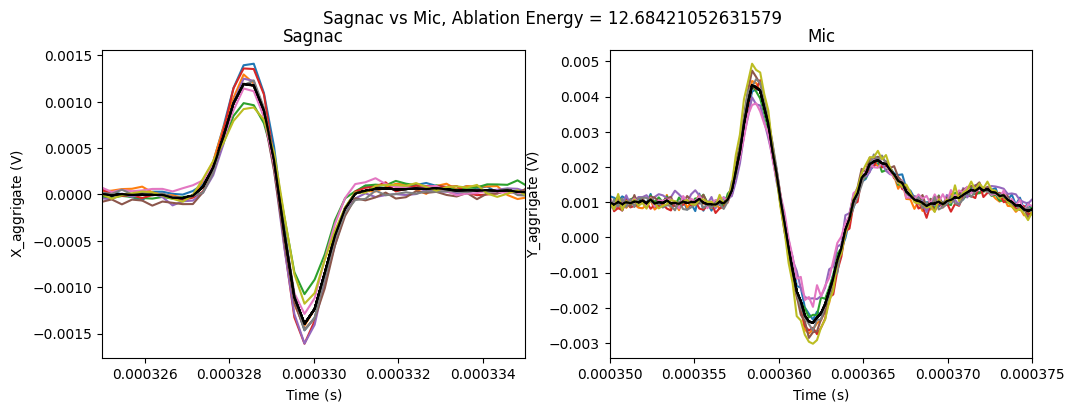

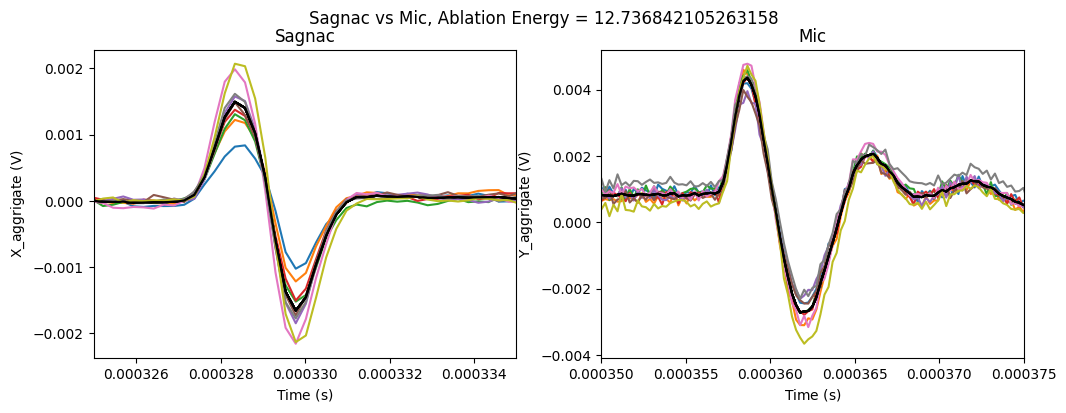

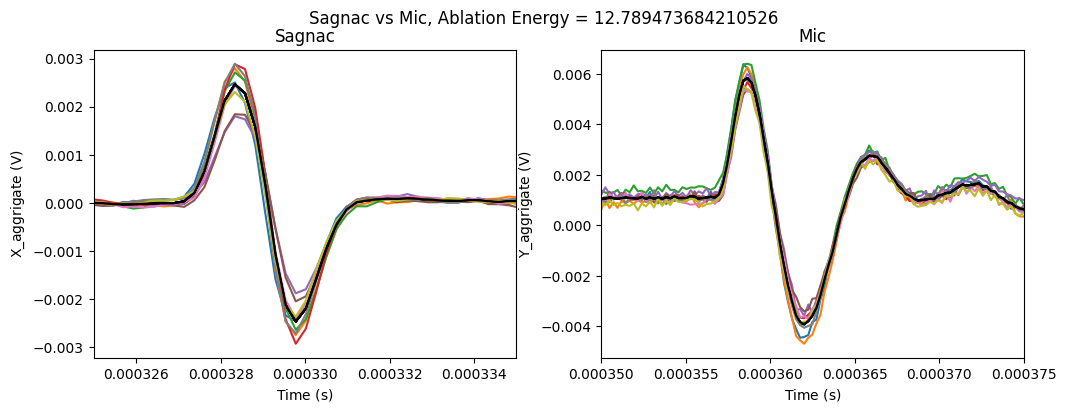

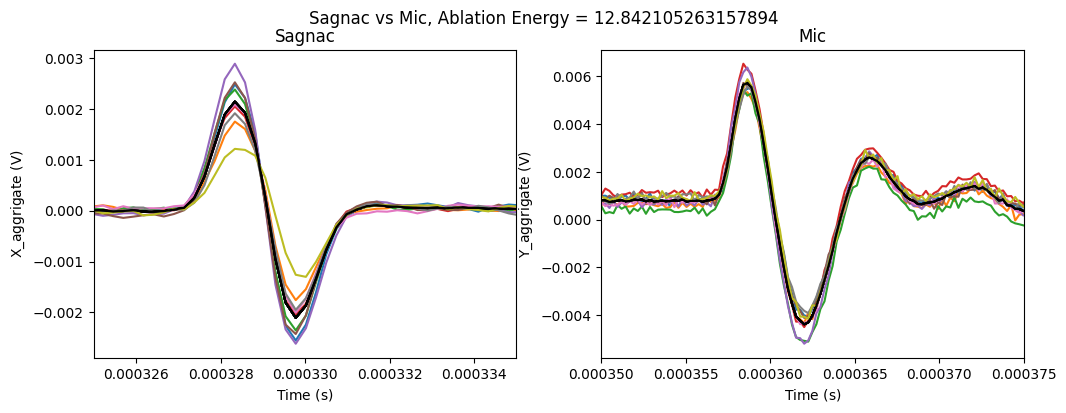

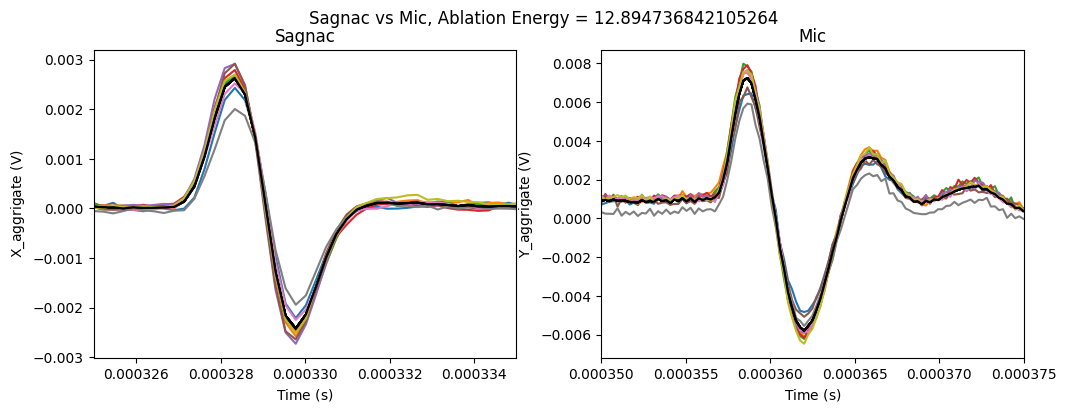

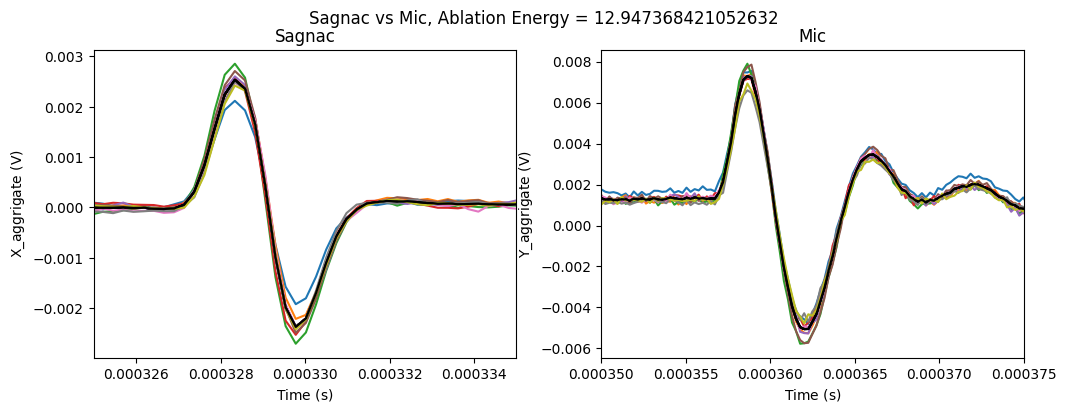

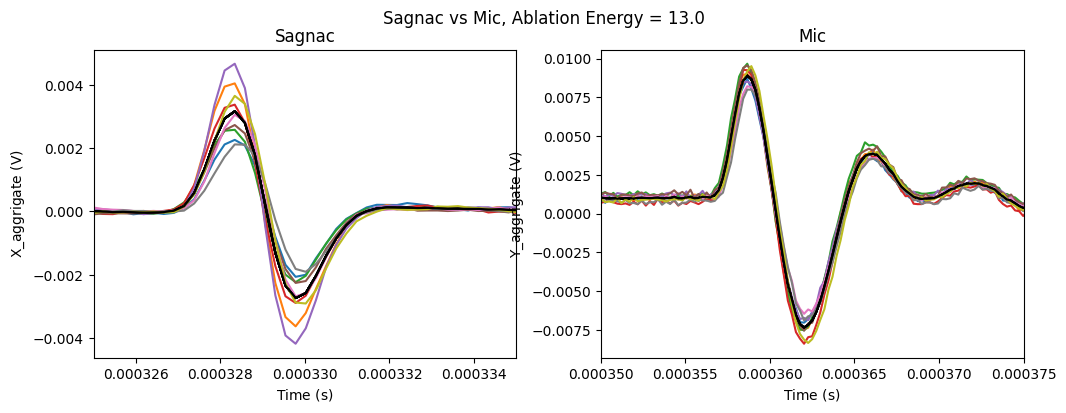

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def Daici(freq, dist = 0.085, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

def integrate(freq):
    return -1j * (2 * np.pi * freq)

for i, (s_dat, m_dat) in enumerate(zip(sagnac_ene_scan.get_data(), mic_ene_scan.get_data())):
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]

    m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
    
    # sagnac_ene_scan.local_detrend(index = i, tmin = 0.0002, tmax = 0.000235, inplace = True)
    s_dat.apply("correct", tmin = 0.00031, tmax = 0.000375, response = Daici, recollect = True)
    s_dat.apply("bin_average", Npts = int(s_dat.r / (2e6 * 2)), inplace = True)
    # s_dat.apply("lowpass", cutoff = 2e5, inplace = True)
    s_dat.apply("detrend", mode = "constant", inplace = True)
    # s_dat.apply("calibrate", cal = -1, inplace = True)

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    ax[0].set_title("Sagnac")
    ax[0].set_xlim([0.000325, 0.000335])
    ax[1].set_title("Mic")
    ax[1].set_xlim([0.00035, 0.000375])
    fig.suptitle("Sagnac vs Mic, Ablation Energy = " + str(s_dat.ene))
    for s_shot, m_shot in zip(s_dat.collection[2:], m_dat.collection[2:]):
        s_dat.aggrigate(collection_slice = slice(2, len(s_dat.collection), 1))
        ax[0].plot(s_shot.t, s_shot.x)
        s_dat.agg.plot(ax = ax[0], c = "k")
        m_dat.aggrigate(collection_slice = slice(2, len(m_dat.collection), 1))
        ax[1].plot(m_shot.t, m_shot.x)
        m_dat.agg.plot(ax = ax[1], c = "k")
    
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]

[ 0.0000e+00 -3.4000e-06 -3.4000e-06 -3.4000e-06 -3.4000e-06 -3.4000e-06
 -3.4000e-06 -6.8000e-06 -6.8000e-06 -6.8000e-06 -6.8000e-06 -1.0200e-05
 -1.0200e-05 -1.0200e-05 -1.3600e-05 -1.3600e-05 -1.7000e-05 -1.7000e-05
 -1.7000e-05 -2.0400e-05 -2.0400e-05 -2.0400e-05 -2.3800e-05 -2.3800e-05
 -2.3800e-05 -2.3800e-05 -2.7200e-05 -2.7200e-05 -2.7200e-05 -2.3800e-05
 -4.0800e-05 -4.0800e-05 -4.7600e-05 -3.7400e-05 -3.4000e-05 -3.0600e-05
 -3.0600e-05 -2.7200e-05 -2.0400e-05 -1.3600e-05 -6.8000e-06  0.0000e+00
  6.8000e-06  6.8000e-06  2.0400e-05 -4.7600e-05 -1.3600e-04 -1.9720e-04
 -4.1480e-04 -3.0600e-04 -2.8220e-04 -3.5020e-04 -4.7940e-04 -8.0920e-04
 -9.0100e-04 -5.2360e-04 -1.2274e-03 -2.4616e-03 -4.7056e-03] 59


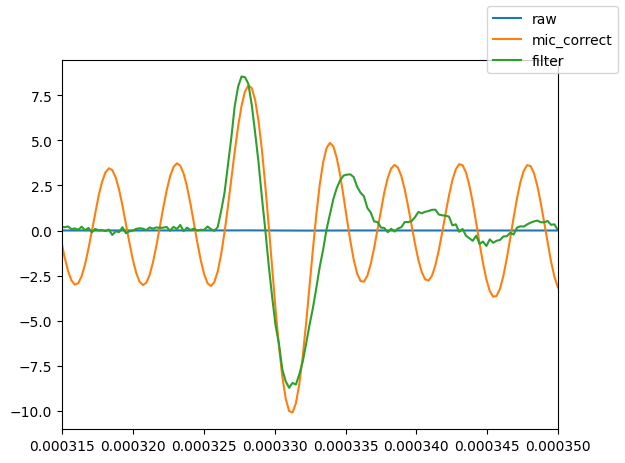

In [7]:
import acoustic_entrainment
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.set_xlim([0.000315, 0.00035])

i = 19
col_ind = 8

def mic_correct(c, taps = 3, lfs = 0.68e-3) -> (list, list):
    """
    mic_correct uses the impulse response function of the microphone
    to correct the signal using a digital filter (scipy.signal.filtfilt).
    :param c: collection object of TDMS object.
    :param lfs: lfs of microphone (provided by manufacturer).
    :return: list of times of the collection data and 
             list of corrected signal of the collection data.
    """
    import acoustic_entrainment
    import scipy.signal as sig
    import numpy as np
    # creating array of gain values using acoustic_entrainment.dBs_orig
    gains = lfs * 10 * acoustic_entrainment.dBs_orig / 20
    # making the filter using sig.firwin2
    # 1st value provided is the number of taps for the filter
    # 2nd value is the range of frequencies for the filter -- specified in acoustic_entrainment
    # 3rd value is the array of gains created above
    # 4th value is the maximum frequency times two
    # this filter is also converted into a minimum phase filter (sig.minimum_phase)
    # lastly, the filter is translated into its inverse using ifft and 1 / fft
    print(gains, len(gains))
    # filter = sig.tf2sos(np.real(np.fft.ifft(1 / np.fft.fft(sig.minimum_phase(sig.firwin2(taps, np.r_[0, acoustic_entrainment.fs_orig], np.r_[0, gains], fs = 2 * acoustic_entrainment.fs_orig[-1]))))), [1])
    filter = np.real(np.fft.ifft(1 / np.fft.fft(sig.minimum_phase(sig.firwin2(taps, np.r_[0, acoustic_entrainment.fs_orig], np.r_[0, gains], fs = 2 * acoustic_entrainment.fs_orig[-1])))))
    # return c.t, sig.sosfilt(filter, c.x)
    return c.t, sig.filtfilt(filter, [1], c.x)

mic_ene_scan.set_data(ind = i)
m_dat = mic_ene_scan.get_data()[i]
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
m_dat.apply("shift", tau = 0.000031, inplace = True)
# m_dat.apply("calibrate", cal = 1 / max(m_dat.collection[8].x), inplace = True)
t, x = m_dat.collection[col_ind].t, m_dat.collection[col_ind].x
ax.plot(t, x, label = "raw")

mic_ene_scan.set_data(ind = i, mic_correct = True)
m_dat = mic_ene_scan.get_data()[i]
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
m_dat.apply("shift", tau = 0.000031, inplace = True)
# m_dat.apply("calibrate", cal = 1 / max(m_dat.collection[8].x), inplace = True)
t, x = m_dat.collection[col_ind].t, m_dat.collection[col_ind].x
ax.plot(t, x, label = "mic_correct")

mic_ene_scan.set_data(ind = i)
m_dat = mic_ene_scan.get_data()[i]
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
m_dat.apply("shift", tau = 0.000031, inplace = True)
t, x = mic_correct(m_dat.collection[col_ind])
# x /= np.max(x)
ax.plot(t, x, label = "filter")

fig.legend()

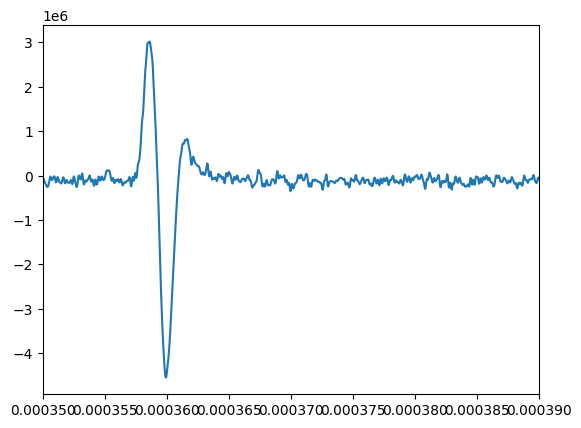

In [19]:
### import acoustic_entrainment
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.set_xlim([0.00035, 0.00039])

def Daici(freq, dist = 0.09, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)
    
def laser_impulse(t, dist = 0.09, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    a = get_sound_speed(T, 0.5, 99e3)
    tau = dist / a
    return (tau ** 2) / np.power((t * (t + (2 * tau))), (3/2))

# s_dat.apply("correct", response = Daici, recollect = True)
# s_dat.apply("detrend", mode = "constant", inplace = True)
# s_dat.apply("bin_average", Npts = int(s_dat.r / (2e6 * 2)), inplace = True)
# s_dat.apply("shift", tau = -0.0000305, inplace = True)
# t, x = s_dat.collection[8].t, s_dat.collection[8].x
# x *= 2
# x /= np.max(x)
# ax.plot(t, x, label = "Daici")
# sagnac_ene_scan.set_data(ind = i)
# s_dat = sagnac_ene_scan.get_data()[i]

# freq = np.linspace(0, 2e6, 10000)
# gains = Daici(freq)
# filter = sig.firwin2(100001, np.r_[0, freq], np.r_[0, gains] ** 2, fs = 2 * freq[-1])
# kernel = sig.minimum_phase(filter)
# inv_kernel = np.fft.ifft(1 / np.fft.fft(kernel))
# s_dat.apply("detrend", mode = "constant", inplace = True)
# # s_dat.apply("bin_average", Npts = int(s_dat.r / (2e6 * 2)), inplace = True)
# s_dat.apply("shift", tau = -0.0000305, inplace = True)
# # t0, x0 = s_dat.collection[8].t, s_dat.collection[8].x
# # x0 /= np.max(x0)
# # ax.plot(t0, x0, label = "sagnac")
# t, x = s_dat.collection[8].t, sig.lfilter(inv_kernel, [1], s_dat.collection[8].x)
# # x /= np.max(x)
# # ax.plot(t, x, label = "sagnac")
# sagnac_ene_scan.set_data(ind = i)
# s_dat = sagnac_ene_scan.get_data()[i]

t = np.linspace(0, 0.001, 11)
impulse = laser_impulse(t[1:])
s_dat.apply("shift", tau = -0.0000305, inplace = True)
t, x = s_dat.collection[8].t[1:], sig.filtfilt(impulse, [1], s_dat.collection[8].x[1:])
ax.plot(t, x)

In [5]:
import matplotlib
print(matplotlib.__version__)

3.7.0
